## NREL WIND Toolkit Domains (CONUS, Canada, Mexico) - HSDS Demo

This notebook demonstrates basic usage of the National Renewable Energy Laboratory (NREL) National Solar Radiation Database (NSRDB) data. The data is provided from Amazon Web Services using the HDF Group's Highly Scalable Data Service (HSDS).

For this to work you must first install h5pyd:

```
pip install --user h5pyd
```

Next you'll need to configure HSDS:

```
hsconfigure
```

and enter at the prompt:

```
hs_endpoint = https://developer.nrel.gov/api/hsds
hs_username = None
hs_password = None
hs_api_key = 3K3JQbjZmWctY0xmIfSYvYgtIcM3CN0cb1Y2w9bf
```

*The example API key here is for demonstation and is rate-limited per IP. To get your own API key, visit https://developer.nrel.gov/signup/*

You can also add the above contents to a configuration file at ~/.hscfg

In [1]:
%matplotlib inline
import h5pyd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial import cKDTree

## Basic Usage

The WIND Toolkit domains are provided in annual .h5 files and currently spans 2007-2014.  
Each year can be accessed from `/nrel/wtk/${country}/wtk_${country}_${year}.h5` where `country` is conus, canada, or mexico

In [2]:
# Open the desired domain year of data
# server endpoint, username, password is found via a config file
f = h5pyd.File("/nrel/wtk/canada/wtk_canada_2012.h5", bucket="s3://nrel-pds-hsds")

In [3]:
list(f.attrs)  # list attributes belonging to the root group

['Version']

In [4]:
f.attrs['Version']   # attributes can be used to provide desriptions of the content

'v1.0.0'

## Datasets

In [5]:
list(f)  # list the datasets in the file

['coordinates',
 'inversemoninobukhovlength_2m',
 'meta',
 'precipitationrate_0m',
 'pressure_0m',
 'pressure_100m',
 'pressure_200m',
 'relativehumidity_2m',
 'temperature_100m',
 'temperature_10m',
 'temperature_120m',
 'temperature_140m',
 'temperature_160m',
 'temperature_200m',
 'temperature_2m',
 'temperature_40m',
 'temperature_60m',
 'temperature_80m',
 'time_index',
 'winddirection_100m',
 'winddirection_10m',
 'winddirection_120m',
 'winddirection_140m',
 'winddirection_160m',
 'winddirection_200m',
 'winddirection_40m',
 'winddirection_60m',
 'winddirection_80m',
 'windspeed_100m',
 'windspeed_10m',
 'windspeed_120m',
 'windspeed_140m',
 'windspeed_160m',
 'windspeed_200m',
 'windspeed_40m',
 'windspeed_60m',
 'windspeed_80m']

In [6]:
# Datasets are stored in a 2d array of time x location
dset = f['windspeed_100m']
dset.shape

(8784, 2894781)

In [7]:
# Extract datetime index for datasets
time_index = pd.to_datetime(f['time_index'][...].astype(str))
time_index # Temporal resolution is 30min

DatetimeIndex(['2012-01-01 00:00:00', '2012-01-01 01:00:00',
               '2012-01-01 02:00:00', '2012-01-01 03:00:00',
               '2012-01-01 04:00:00', '2012-01-01 05:00:00',
               '2012-01-01 06:00:00', '2012-01-01 07:00:00',
               '2012-01-01 08:00:00', '2012-01-01 09:00:00',
               ...
               '2012-12-31 14:00:00', '2012-12-31 15:00:00',
               '2012-12-31 16:00:00', '2012-12-31 17:00:00',
               '2012-12-31 18:00:00', '2012-12-31 19:00:00',
               '2012-12-31 20:00:00', '2012-12-31 21:00:00',
               '2012-12-31 22:00:00', '2012-12-31 23:00:00'],
              dtype='datetime64[ns]', length=8784, freq=None)

In [8]:
# Locational information is stored in either 'meta' or 'coordinates'
meta = pd.DataFrame(f['meta'][...])
meta.head()

,latitude,longitude,country,state,county,timezone,elevation,offshore,source
0,48.459221,-130.720367,b'None',b'None',b'None',-9.0,0.0,1,b'WTK_Canada (NARIS)'
1,48.474941,-130.733322,b'None',b'None',b'None',-9.0,0.0,1,b'WTK_Canada (NARIS)'
2,48.490665,-130.746277,b'None',b'None',b'None',-9.0,0.0,1,b'WTK_Canada (NARIS)'
3,48.506378,-130.759247,b'None',b'None',b'None',-9.0,0.0,1,b'WTK_Canada (NARIS)'
4,48.522099,-130.772232,b'None',b'None',b'None',-9.0,0.0,1,b'WTK_Canada (NARIS)'


In [9]:
# Datasets have been saved as integers
dset.dtype

dtype('uint16')

In [10]:
dset.shape[0] * dset.shape[1] * 2 * 10**-9 # 51 GB per dataset!

50.855512608000005

In [11]:
dset.chunks # Chunked by week

(1344, 744)

In [12]:
dset.chunks[0] * dset.chunks[1] * dset.dtype.itemsize * 10**-6 # 2 MB per chunk

1.9998719999999999

In [13]:
# To convert dataset values back to floats use the 'scale_factor'
dset.attrs['scale_factor']

100.0

In [14]:
scale_factor = dset.attrs['scale_factor']
units = dset.attrs['units']
print('wind speed scale factor = ', scale_factor)
print('wind speed units after unscaling = ', units)
dset[0, 0] / scale_factor # divide by scale_factor to return native value

wind speed scale factor =  100.0
wind speed units after unscaling =  m s-1


21.84

## Time-slicing

Get the time_index from the server and convert to a pandas DatetimeIndex for convenience:

In [15]:
time_index = pd.to_datetime(f['time_index'][...].astype(str))
time_index

DatetimeIndex(['2012-01-01 00:00:00', '2012-01-01 01:00:00',
               '2012-01-01 02:00:00', '2012-01-01 03:00:00',
               '2012-01-01 04:00:00', '2012-01-01 05:00:00',
               '2012-01-01 06:00:00', '2012-01-01 07:00:00',
               '2012-01-01 08:00:00', '2012-01-01 09:00:00',
               ...
               '2012-12-31 14:00:00', '2012-12-31 15:00:00',
               '2012-12-31 16:00:00', '2012-12-31 17:00:00',
               '2012-12-31 18:00:00', '2012-12-31 19:00:00',
               '2012-12-31 20:00:00', '2012-12-31 21:00:00',
               '2012-12-31 22:00:00', '2012-12-31 23:00:00'],
              dtype='datetime64[ns]', length=8784, freq=None)

Extract indexes for a particular span of time:

In [16]:
march = time_index.month == 3
np.where(march)[0]

array([1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450,
       1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461,
       1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472,
       1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483,
       1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494,
       1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505,
       1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516,
       1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527,
       1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538,
       1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549,
       1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560,
       1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571,
       1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582,
       1583, 1584, 1585, 1586, 1587, 1588, 1589, 15

Or a particular date:

In [17]:
timestep = np.where(time_index == '2012-07-04 00:00:00')[0][0]
timestep

4440

## Map Data

In [18]:
# Extract coordinates (lat, lon)
print(dict(f['coordinates'].attrs))
coords = f['coordinates'][...]

{'description': '(latitude, longitude)'}


In [19]:
%time data = dset[timestep, ::100]   # extract every 100th location at a particular time
df = pd.DataFrame() # Combine data with coordinates in a DataFrame
df['longitude'] = coords[::100, 1]
df['latitude'] = coords[::100, 0]
df['windspeed_100m'] = data / dset.attrs['scale_factor'] # unscale dataset

CPU times: user 4.04 ms, sys: 1.49 ms, total: 5.53 ms
Wall time: 1min 18s


In [20]:
df.shape

(28948, 3)

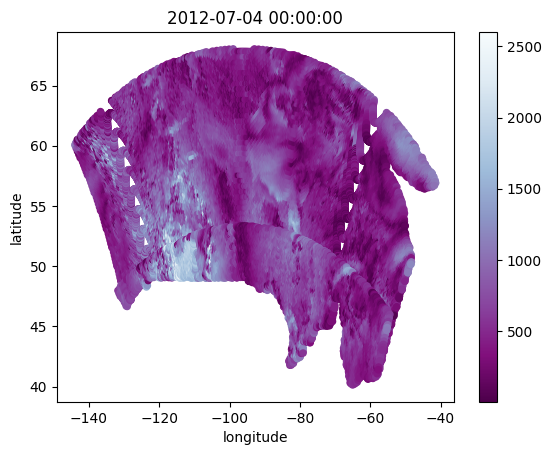

In [23]:
df.plot.scatter(x='longitude', y='latitude', c=data,
                colormap='BuPu_r',
                title=str(time_index[timestep]))
plt.show()

In [24]:
meta = pd.DataFrame(f['meta'][...])
meta['state'].unique()

array([b'None', b'Alaska', b'British Columbia', b'Yukon',
       b'Northwest Territories', b'Alberta', b'Saskatchewan', b'Nunavut',
       b'Manitoba', b'Qaasuitsup', b'Ontario', b'Qu\xc3\xa9bec',
       b'Newfoundland and Labrador', b'Miquelon-Langlade',
       b'Saint-Pierre', b'New York', b'New Brunswick', b'Maine',
       b'Nova Scotia', b'Prince Edward Island'], dtype=object)

In [25]:
# Full resolution subset of Colorado
meta = pd.DataFrame(f['meta'][...])
CA = meta.loc[meta['state'] == b'California'] # Note .h5 saves strings as bit-strings
CA.head()

,latitude,longitude,country,state,county,timezone,elevation,offshore,source


In [26]:
%time data = dset[timestep][CA.index]  # full-resolution subset
df = CA[['longitude', 'latitude']].copy()
df['windspeed_100m'] = data / dset.attrs['scale_factor']
df.shape

CPU times: user 23.2 ms, sys: 5.29 ms, total: 28.5 ms
Wall time: 1min 18s


(0, 3)

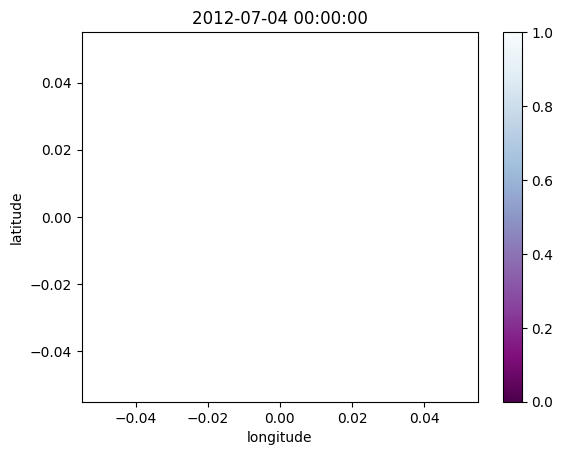

In [27]:
df.plot.scatter(x='longitude', y='latitude', c=data,
                colormap='BuPu_r',
                title=str(time_index[timestep]))
plt.show()

## Nearest Timeseries for given Lat/Lon

In [ ]:
# Unlike the gridded WTK data the NSRDB is provided as sparse time-series dataset.
# The quickest way to find the nearest site it using a KDtree

dset_coords = f['coordinates'][...]
tree = cKDTree(dset_coords)
def nearest_site(tree, lat_coord, lon_coord):
    lat_lon = np.array([lat_coord, lon_coord])
    dist, pos = tree.query(lat_lon)
    return pos

NewYorkCity = (40.7128, -74.0059)
NewYorkCity_idx = nearest_site(tree, NewYorkCity[0], NewYorkCity[1] )

print("Site index for New York City: \t\t {}".format(NewYorkCity_idx))
print("Coordinates of New York City: \t {}".format(NewYorkCity))
print("Coordinates of nearest point: \t {}".format(dset_coords[NewYorkCity_idx]))

In [ ]:
# Get the entire 2012 timeseries data for a point in NYC
%time tseries = dset[:, NewYorkCity_idx] / dset.attrs['scale_factor']

In [ ]:
len(tseries)   # 1 years * 365 days * 24 hours * 30 minutes

In [ ]:
plt.plot(time_index, tseries)
plt.ylabel("wspd")
plt.title("NYC ghi in 2012")

## GHI Statistics

In [ ]:
df = pd.DataFrame({'wspd': tseries}, index=time_index)
df["year"] = df.index.year
df["month"] = df.index.month
df["day"] = df.index.day
df["hour"] = df.index.hour

agg = df.groupby(["month","hour"]).mean()
agg = agg.reset_index().pivot(index="month",columns="hour",values="wspd")
agg

In [ ]:
plt.imshow(agg)
plt.xlabel("Hour")
plt.ylabel("Month")
plt.title("12 x 24 Mean Wind Speed (m/s)")
plt.colorbar()